## Price Movement Classification Models

Part 1: Data Cleaning and Preprocessing

In [77]:
import pandas as pd
import numpy as np
import datetime as dt
import sys
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
import itertools
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [43]:
def clean_data(path):
    '''
    Function that cleans TAQ data by subsetting for specific time interval by minute
    '''
    # Create more consolidated time columns
    df = pd.read_csv(path)
    df["Date-Time"] = pd.to_datetime(df["Date-Time"])
    df.insert(2, "Date", df["Date-Time"].dt.date)
    df.insert(3, "Time", df["Date-Time"].dt.time)
    df.insert(4, "Hour-Minute", df['Date-Time'].dt.strftime('%H:%M'))
    df.drop("Date-Time", axis = 1, inplace=True)
    
    # Subset data to be within 11:00 AM and 4:00 PM (last 5 hours of trading day)
    df = df[df["Hour-Minute"] > '10:59']
    df = df[df["Hour-Minute"] < '16:01']
    df.reset_index(inplace=True)
    df.drop("index",axis=1,inplace=True)
    
    #For each unique minute, get all trades and all quotes
    unique_times = list(df["Hour-Minute"].unique())
    final_times = []
    for time in unique_times:
        time_df = df[df["Hour-Minute"] ==  time]
        if(len(time_df[time_df["Type"] == "Trade"]) != 0):
            final_times.append(time)
    
    final_data_list = []
    for time in final_times:
        time_df = df[df["Hour-Minute"] == time]
        final_data_list.append(time_df)
    final_data = pd.concat(final_data_list)
    return final_data

In [44]:
def calc_returns(df):
    '''
    Function that takes in cleaned dataframe and calculates minute-by-minute returns from trade prices and calculates 
    return quantile buckets
    '''
    minute_df = df[df["Type"] == "Trade"]
    price_list = []
    unique_times = list(minute_df["Hour-Minute"].unique())
    
    for time in unique_times:
        first_trade = minute_df[minute_df["Hour-Minute"] == time].head(1)
        price_list.append(first_trade["Price"])
    
    price_list = [float(x) for x in price_list]
    returns_df = pd.DataFrame(list(zip(unique_times, price_list)), columns = ["Time", "Price"])
    
    returns_df["Returns"] = returns_df["Price"].pct_change()
    returns_df.dropna(inplace=True)

    quantiles = returns_df["Returns"].quantile([.25, .5, .75])
    q1, q2, q3 = quantiles.iloc[0], quantiles.iloc[1], quantiles.iloc[2]
    
    #conditions = [(returns_df['Returns'] <= q1),
    #(returns_df["Returns"] > q1) & (returns_df['Returns'] <= q2),
    #(returns_df['Returns'] > q2) & (returns_df['Returns'] <= q3),
    #(returns_df['Returns'] > q3)]
    
    conditions = [(returns_df["Returns"] < 0), 
                (returns_df["Returns"] == 0),
                returns_df["Returns"] > 0]
    
    values = ["Down", "Flat", "Up"]
    returns_df["Direction"] = np.select(conditions, values)
    return returns_df

In [45]:
def calc_liquidity_measures(returns_df, minute_df):
    '''
    Function that calculates liquidity measures using TAQ data and backfills into final dataframe as factors for model
    
    Measure 1: Turnover (Sum of trade prices * trade volumes)
    Measure 2: Market Depth (Sum of average bid and ask sizes)
    Measure 3: Log Depth (Sum of average log-bid and log-ask sizes)
    Measure 4: Dollar Depth 
    Measure 5: Spread
    Measure 6: Relative Spread (mid)
    Measure 7: Relative Spread (last)
    Measure 8: Relative Spread (log)
    Measure 9: Effective Spread
    Measure 10: Relative Effective Spread (last)
    Measure 11: Relative Effective Spread (Mid)
    Measure 12: Quote Slope
    Measure 13: Log-Quote Slope
    Measure 14: Adjusted Log Quote Slope
    Measure 15: Composite Liquidity
    Measure 16: Liquidity Ratio 1 (Amivest)
    Measure 17: Flow Ratio
    Measure 18: Order Ratio
    Measure 19: Illiqudity (Amihud)
    '''
    unique_times = list(returns_df["Time"].unique())
    turnover_list, mdepth_list, ldepth_list, ddepth_list, sprd_list, msprd_list, lsprd_list = [], [], [], [], [], [], []
    logsprd_list, effsprd_list, esprdlast_list, esprdmid_list, qslope_list, lqslope_list = [], [], [], [], [], []
    adjlqslope_list, clqi_list, lratio_list, fratio_list, oratio_list, ill_list = [], [], [], [], [], []
    
    for time in unique_times: 
        time_df = minute_df[minute_df["Hour-Minute"] == time]
        trades = time_df[time_df["Type"] == "Trade"]
        quotes = time_df[time_df["Type"] == "Quote"]
        returns_time = returns_df[returns_df["Time"] == time]
        price = float(returns_time["Price"])
        rtn = float(returns_time["Returns"])
        vol_list = list(trades["Volume"])
        turnover = (trades['Price'] * trades['Volume']).sum()
        turnover_list.append(float(turnover))
        
        avg_bsize, avg_asize, avg_bprice, avg_aprice = float(np.average(quotes["Bid Size"])), float(np.average(quotes["Ask Size"])), float(np.average(quotes["Bid Price"])), float(np.average(quotes["Ask Price"]))
        mdepth_list.append(avg_bsize + avg_asize)
        ldepth_list.append(np.log(avg_bsize) + np.log(avg_asize))
        ddepth_list.append(0.5*((avg_asize*avg_aprice) + (avg_bsize*avg_bprice)))
        sprd_list.append(avg_aprice-avg_bprice)
        msprd_list.append((2*(avg_aprice-avg_bprice))/(avg_aprice+avg_bprice))
        lsprd_list.append((avg_aprice-avg_bprice)/(price))
        logsprd_list.append(np.log(avg_aprice)-np.log(avg_bprice))
        avg_mprice = 0.5*(avg_bprice+avg_aprice)
        effsprd_list.append(np.abs(price-avg_mprice))
        esprdlast_list.append((np.abs(price-avg_mprice))/(price))
        esprdmid_list.append((np.abs(price-avg_mprice))/(avg_mprice))
        qslope_list.append((avg_aprice-avg_bprice)/(np.log(avg_asize)-np.log(avg_bsize)))
        lqslope = (np.log(avg_aprice)-np.log(avg_bprice))/(np.log(avg_asize*avg_bsize))
        lqslope_list.append(lqslope)
        adjlqslope_list.append(lqslope*(1+np.abs(np.log(avg_asize/avg_bsize))))
        clqi_list.append((2*(avg_aprice-avg_bprice))/(avg_mprice*(avg_asize*avg_aprice + avg_bsize*avg_bprice)))
        lratio_list.append(turnover/np.abs(rtn))
        fratio_list.append(len(trades["Type"]) * turnover)
        oratio_list.append((np.abs(avg_bsize-avg_asize))/turnover)
        ill_list.append(np.average([rtn/x for x in vol_list]))
    
    returns_df["Turnover"] = turnover_list
    returns_df["Market Depth"] = mdepth_list
    returns_df["Log Depth"] = ldepth_list
    returns_df["Dollar Depth"] = ddepth_list
    returns_df["Absolute Spread"] = sprd_list
    returns_df["Relative Spread (Mid)"] = msprd_list
    returns_df["Relative Spread (Last)"] = lsprd_list
    returns_df["Relative Spread (Log)"] = logsprd_list
    returns_df["Effective Spread"] = effsprd_list
    returns_df["Relative Effective Spread (Last)"] = esprdlast_list
    returns_df["Relative Effective Spread (Mid)"] = esprdmid_list
    returns_df["Quote Slope"] = qslope_list
    returns_df["Log Quote Slope"] = lqslope_list
    returns_df["Adjusted Log Quote Slope"] = adjlqslope_list
    returns_df["Composite Liquidity"] = clqi_list
    returns_df["Liquidity Ratio"] = lratio_list
    returns_df["Flow Ratio"] = fratio_list
    returns_df["Order Ratio"] = oratio_list
    returns_df["Illiquidity"] = ill_list
    returns_df["Lagged Returns"] = returns_df["Returns"].shift(1)
    returns_df = returns_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    return returns_df

In [46]:
cvx_cleaned = clean_data("Data\CVX_TAQ_20220314.csv")
cvx_returns = calc_returns(cvx_cleaned)
cvx_final = calc_liquidity_measures(cvx_returns, cvx_cleaned)

In [47]:
cvx_final = cvx_final.iloc[:, 3:]
cvx_final["Direction"] = cvx_final["Direction"].shift(-1)

In [48]:
cvx_final.dropna(inplace=True)

Part 2: Model Implementation

In [49]:
def split_scale_data(df):
    '''
    Function that performs a 80-20 train test split and uses a min max scaler to scale feature (X) data 
    '''
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
    train_features = pd.DataFrame(X_train_scaled, columns = X_train.columns)
    return X_train_scaled, X_test_scaled, y_train, y_test, train_features

In [50]:
def log_reg(X_train, X_test, y_train, y_test):
    '''
    Function that implements a basic logistic regression and prints accuracy and confusion matrix and returns test predictions
    '''
    model = LogisticRegression(multi_class='multinomial')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(metrics.accuracy_score(y_pred, y_test))
    print(metrics.confusion_matrix(y_test, y_pred))
    return y_pred

In [106]:
def svm_model(X_train, X_test, y_train, y_test):
    '''
    Function that implements a basic SVM and prints accuracy and confusion matrix and returns test predictions
    '''
    clf = svm.SVC(kernel = 'linear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(metrics.accuracy_score(y_pred, y_test))
    print(metrics.confusion_matrix(y_test, y_pred))
    return y_pred

In [52]:
def rf(X_train, X_test, y_train, y_test):
    classifier_rf = RandomForestClassifier(n_estimators=200)
    classifier_rf.fit(X_train, y_train)
    y_pred = classifier_rf.predict(X_test)
    print(metrics.accuracy_score(y_pred, y_test))
    print(metrics.confusion_matrix(y_test, y_pred))
    return y_pred

In [53]:
X_train, X_test, y_train, y_test, train_features = split_scale_data(cvx_final)

In [54]:
log_preds = log_reg(X_train, X_test, y_train, y_test)

0.6274509803921569
[[25  4]
 [15  7]]


In [107]:
svm_preds = svm_model(X_train, X_test, y_train, y_test)

0.6274509803921569
[[28  1]
 [18  4]]


In [56]:
rf_preds = rf(X_train, X_test, y_train, y_test)

0.6078431372549019
[[22  7]
 [13  9]]


Part 3: Feature Importance - Subset Selection

In [57]:
def fit_model(X,Y,flag):
    '''
    Function that fits a LR or SVM model depending on user info and returns accuracy
    '''
    if flag == "LR":
        model_k = LogisticRegression(multi_class='multinomial')
    if flag == 'SVM':
        model_k = svm.SVC()
    else:
        model_k = RandomForestClassifier(n_estimators=200)
    model_k.fit(X,Y)
    acc = metrics.accuracy_score(Y,model_k.predict(X))
    return acc

In [58]:
def feature_selection(X_train, y_train, flag):
    '''
    Function that performs a forward subset selection to return the combination of features that result in highest train 
    accuracy for model
    '''
    k = len(X_train.columns)
    acc_list = []
    rem_features = list(X_train.columns.values)
    features = []
    features_list = dict()
    
    for i in range(1,k):
        best_acc = 0
        for combo in itertools.combinations(rem_features,1):
            acc = fit_model(X_train[list(combo) + features], y_train, flag)
            
            if acc > best_acc:
                best_acc = acc
                best_feature = combo[0]
        features.append(best_feature)
        rem_features.remove(best_feature)
        acc_list.append(best_acc)
        features_list[i] = features.copy()
    best_combo_idx = acc_list.index(max(acc_list))
    print("Best Features: ", features_list[best_combo_idx+1])
    print("Best Accuracy: ", acc_list[best_combo_idx])

In [59]:
feature_selection(train_features, y_train, "LR")

Best Features:  ['Turnover']
Best Accuracy:  1.0


In [60]:
feature_selection(train_features, y_train, "SVM")

Best Features:  ['Log Depth', 'Liquidity Ratio', 'Turnover', 'Relative Spread (Last)', 'Adjusted Log Quote Slope']
Best Accuracy:  0.6435643564356436


In [61]:
feature_selection(train_features, y_train, "RF")

Best Features:  ['Turnover']
Best Accuracy:  1.0


In [62]:
lr_rf_df = cvx_final[["Direction", "Turnover"]]

In [63]:
X_train, X_test, y_train, y_test, train_features = split_scale_data(lr_rf_df)

In [64]:
log_preds = log_reg(X_train, X_test, y_train, y_test)

0.5490196078431373
[[28  1]
 [22  0]]


In [65]:
rf_preds = rf(X_train, X_test, y_train, y_test)

0.5098039215686274
[[16 13]
 [12 10]]


In [66]:
svm_df = cvx_final[["Direction", 'Log Depth', 'Liquidity Ratio', 'Turnover', 'Relative Spread (Last)', 'Adjusted Log Quote Slope']]
X_train, X_test, y_train, y_test, train_features = split_scale_data(svm_df)
svm_preds = svm_model(X_train, X_test, y_train, y_test)

0.6274509803921569
[[27  2]
 [17  5]]


Part 4: Feature Importance - Model Features

In [87]:
# Random Forest Feature Importance
X_train, X_test, y_train, y_test, train_features = split_scale_data(cvx_final)

def rf_importances(X_train, X_test, y_train, y_test, train_features):
    classifier_rf = RandomForestClassifier(n_estimators=200)
    classifier_rf.fit(X_train, y_train)
    y_pred = classifier_rf.predict(X_test)
    importances = classifier_rf.feature_importances_
    feature_names = list(train_features.columns)
    std = np.std([tree.feature_importances_ for tree in classifier_rf.estimators_], axis=0)
    
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances.sort_values(ascending = False, inplace=True)
    print(forest_importances)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.savefig("RF_FeatureSelection.pdf")

Illiquidity                         0.070994
Liquidity Ratio                     0.061033
Flow Ratio                          0.060919
Order Ratio                         0.059932
Turnover                            0.056943
Market Depth                        0.056637
Log Depth                           0.055542
Lagged Returns                      0.054507
Dollar Depth                        0.051722
Quote Slope                         0.051234
Adjusted Log Quote Slope            0.049030
Relative Effective Spread (Mid)     0.047602
Effective Spread                    0.045890
Composite Liquidity                 0.044387
Relative Effective Spread (Last)    0.042841
Log Quote Slope                     0.042162
Absolute Spread                     0.039632
Relative Spread (Last)              0.038425
Relative Spread (Log)               0.035976
Relative Spread (Mid)               0.034592
dtype: float64


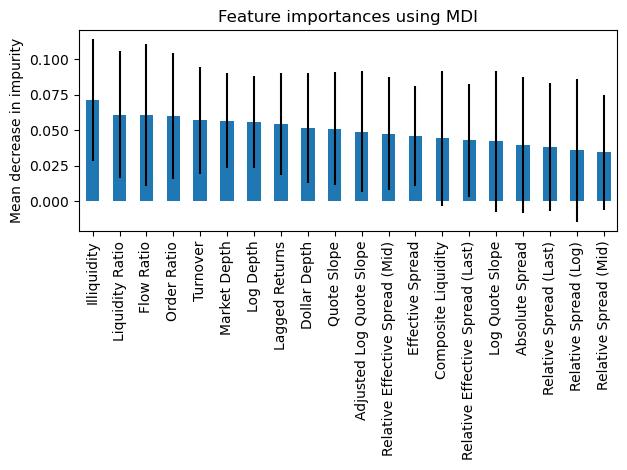

In [88]:
rf_importances(X_train, X_test, y_train, y_test, train_features)

In [131]:
# SVM Feature Importances
X_train, X_test, y_train, y_test, train_features = split_scale_data(cvx_final)

def svm_features(X_train, X_test, y_train, y_test, train_features):
    '''
    Function that implements a basic SVM and prints accuracy and confusion matrix and returns test predictions
    '''
    clf = svm.SVC(kernel = 'linear')
    clf.fit(X_train, y_train)
    svm_imp = pd.Series(abs(clf.coef_[0]), index=train_features.columns)
    svm_imp.sort_values(inplace=True, ascending=False)
    
    svm_imp.plot(kind='bar')
    print(svm_imp)
    plt.title("SVM Feature Importance")
    plt.savefig("SVM_FeatureSelection.pdf")

Liquidity Ratio                     1.576327
Market Depth                        1.124617
Dollar Depth                        1.110485
Flow Ratio                          1.021876
Composite Liquidity                 0.874441
Turnover                            0.841575
Log Quote Slope                     0.699300
Log Depth                           0.605234
Absolute Spread                     0.392969
Relative Spread (Log)               0.377530
Relative Spread (Mid)               0.377529
Lagged Returns                      0.370515
Relative Spread (Last)              0.363824
Adjusted Log Quote Slope            0.356564
Order Ratio                         0.327394
Relative Effective Spread (Mid)     0.120187
Effective Spread                    0.118867
Relative Effective Spread (Last)    0.114994
Illiquidity                         0.079654
Quote Slope                         0.032726
dtype: float64


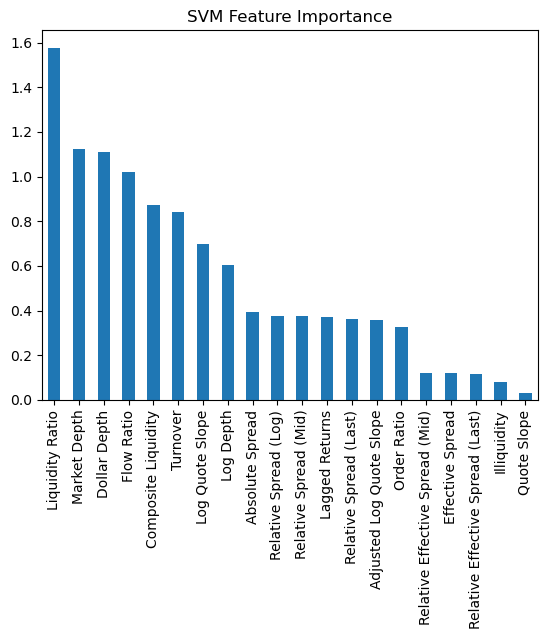

In [132]:
svm_features(X_train, X_test, y_train, y_test, train_features)